 # Explore Multi-Label Classification with an Enzyme Substrate Dataset
 
"The dataset for this competition (both train and test) was generated from a deep learning model trained on a portion of the Multi-label Classification of enzyme substrates. This dataset only uses a subset of features from the original (the features that had the most signal). Feature distributions are close to, but not exactly the same, as the original."

The **aim** is to preditc the featues EC1 and EC2

**Evaluation**: Submissions are evaluated on area under the ROC curve between the predicted probability and the ground truth for each target, and the final score is the average of the individual AUCs of each predicted column.

**Sources**:

- [Kaggle challenge](https://www.kaggle.com/competitions/playground-series-s3e18/overview/description)
- [Original Dataset](https://www.kaggle.com/datasets/gopalns/ec-mixed-class)

# Outline
- [ 1 - Read Data ](#1) 
- [ 2 - EDA - Exploratory Data Analysis](#2)
- [ 3 - Preprocessing Data Before Modeling](#3)
- [ 4 - Model Training](#4)
- [ 5 - Model Comparison](#5)
- [ 6 - Model Tuning](#6)
- [ 7 - Model Diagnostic](#7)
- [ 8 - Challenge Submission](#8)

In [2]:
# importing standard libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, LearningCurveDisplay, ShuffleSplit

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

In [3]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'axes.titlesize': 16,
    'figure.figsize': (12, 4),
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('colorblind'), 
              rc=theme_parameters)

<a name="1"></a>
# Read Data

In [4]:
read_from_kaggle = False

In [8]:
if read_from_kaggle:
    
    data = pd.read_csv('',
                       index_col=0)
    test_data = pd.read_csv('',
                       index_col=0)
    orig_data = pd.read_csv('',
                            index_col=0)
    
    
else:

    train_data = pd.read_csv("./../../data/enzyme_substrate_train.csv",
                            index_col=0)
    test_data = pd.read_csv("./../../data/enzyme_substrate_test.csv",
                            index_col=0)
    #orig_data = pd.read_csv("./../../data/enzyme_substratee_original.csv",
                            #index_col=0)

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14838 entries, 0 to 14837
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BertzCT            14838 non-null  float64
 1   Chi1               14838 non-null  float64
 2   Chi1n              14838 non-null  float64
 3   Chi1v              14838 non-null  float64
 4   Chi2n              14838 non-null  float64
 5   Chi2v              14838 non-null  float64
 6   Chi3v              14838 non-null  float64
 7   Chi4n              14838 non-null  float64
 8   EState_VSA1        14838 non-null  float64
 9   EState_VSA2        14838 non-null  float64
 10  ExactMolWt         14838 non-null  float64
 11  FpDensityMorgan1   14838 non-null  float64
 12  FpDensityMorgan2   14838 non-null  float64
 13  FpDensityMorgan3   14838 non-null  float64
 14  HallKierAlpha      14838 non-null  float64
 15  HeavyAtomMolWt     14838 non-null  float64
 16  Kappa3             148

In [16]:
train_data.head()

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
id,,,,,,,,,,,,,,,,,,,,,
0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,11.938294,...,4.794537,35.527357,0,0,1,1,0,0,0,0
1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,0.000000,...,13.825658,44.707310,0,0,0,1,1,0,0,0
2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,6.606882,...,17.964475,45.660120,0,0,1,1,0,0,1,0
3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,0.000000,...,31.961948,87.509997,0,0,1,1,0,0,0,0
4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,12.841643,...,9.589074,33.333333,2,2,1,0,1,1,1,0


In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9893 entries, 14838 to 24730
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BertzCT            9893 non-null   float64
 1   Chi1               9893 non-null   float64
 2   Chi1n              9893 non-null   float64
 3   Chi1v              9893 non-null   float64
 4   Chi2n              9893 non-null   float64
 5   Chi2v              9893 non-null   float64
 6   Chi3v              9893 non-null   float64
 7   Chi4n              9893 non-null   float64
 8   EState_VSA1        9893 non-null   float64
 9   EState_VSA2        9893 non-null   float64
 10  ExactMolWt         9893 non-null   float64
 11  FpDensityMorgan1   9893 non-null   float64
 12  FpDensityMorgan2   9893 non-null   float64
 13  FpDensityMorgan3   9893 non-null   float64
 14  HallKierAlpha      9893 non-null   float64
 15  HeavyAtomMolWt     9893 non-null   float64
 16  Kappa3             

In [19]:
test_data.head()

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
id,,,,,,,,,,,,,,,,,,,,,
14838,344.632371,7.283603,4.473966,5.834958,3.412257,4.651530,2.096558,1.116433,49.458581,0.000000,...,13.512441,0.000000,0.000000,0.000000,26.809272,24.539800,4.794537,47.304082,1,1
14839,1432.410201,10.663869,7.079026,8.065215,5.297097,5.297097,3.924155,2.569694,0.000000,29.783175,...,0.000000,34.947374,98.323987,9.606882,0.000000,53.378235,0.000000,43.166667,0,0
14840,83.352608,3.931852,1.774215,1.774215,1.073446,1.073446,0.467830,0.170838,5.969305,6.420822,...,5.969305,0.000000,0.000000,6.420822,11.752550,13.344559,9.589074,24.666667,1,1
14841,150.255712,5.912790,3.548812,3.548812,2.595128,2.595128,1.642813,0.694113,0.000000,0.000000,...,59.935299,0.000000,0.000000,0.000000,17.744066,32.290168,4.794537,26.778866,0,0
14842,1817.276351,24.910940,15.540529,20.047314,12.535886,17.730988,11.979618,4.431173,84.554972,47.360206,...,23.468091,25.609359,0.000000,37.099000,69.141353,38.704130,50.697492,102.583333,0,0


In [17]:
# Setting EC1 and EC2 as category type
train_data[column] = train_data[column].astype('category')

<a name="2"></a>
# EDA - Exploratory Data Analysis

## Numeric Feature Distribution Train vs Test Data KDEs

In [24]:
train_data.columns

Index(['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
       'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'],
      dtype='object')

In [25]:
test_data.columns

Index(['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
       'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2'],
      dtype='object')

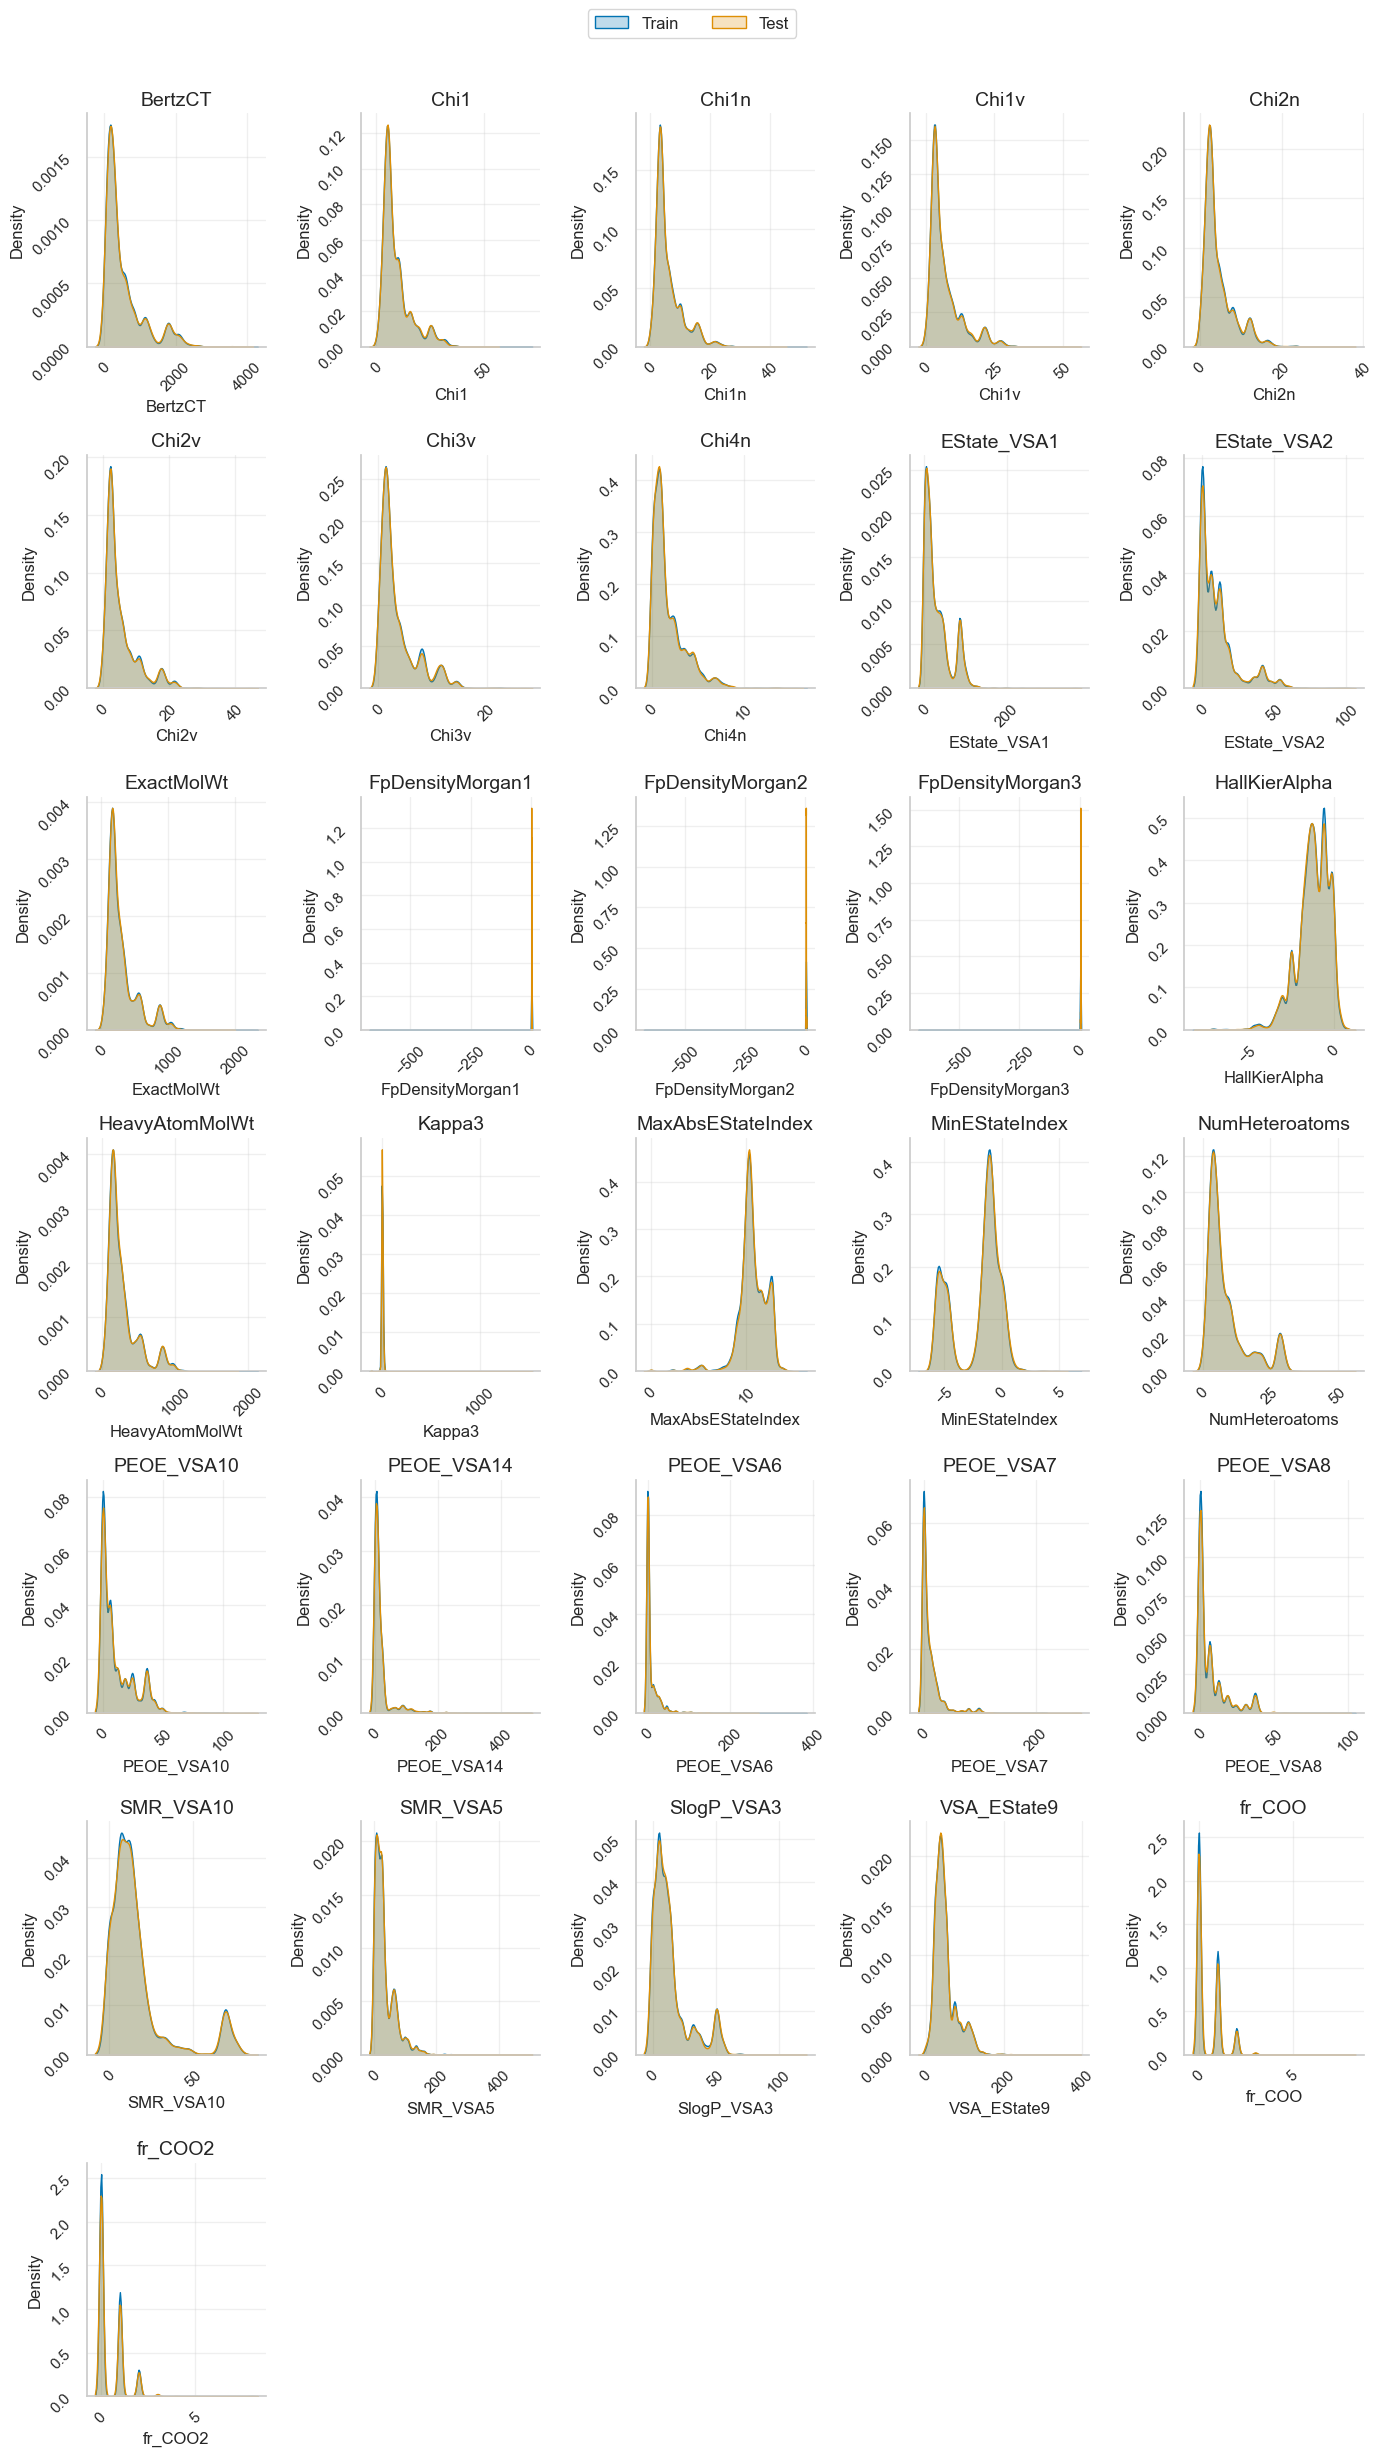

In [27]:
figure, ax = plt.subplots(7, 5, figsize=(14, 24))
ax = ax.flatten()

# create a list to exclude categorical features and the label
exclude_columns = ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6']

for index, col_name in enumerate([col for col in train_data.columns if col not in exclude_columns]):
    
    sns.kdeplot(data=train_data[col_name],
                label='Train',
                fill=True,
                ax=ax[index])
    
    sns.kdeplot(data=test_data[col_name],
                label='Test',
                fill=True,
                ax=ax[index])
   
    ax[index].set_title(col_name, fontsize=14)
    
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
# Remove the empty subplots
figure.delaxes(ax[-4])
figure.delaxes(ax[-3])
figure.delaxes(ax[-2])
figure.delaxes(ax[-1])
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

plt.tight_layout()
plt.show()

## Label Bar Plot

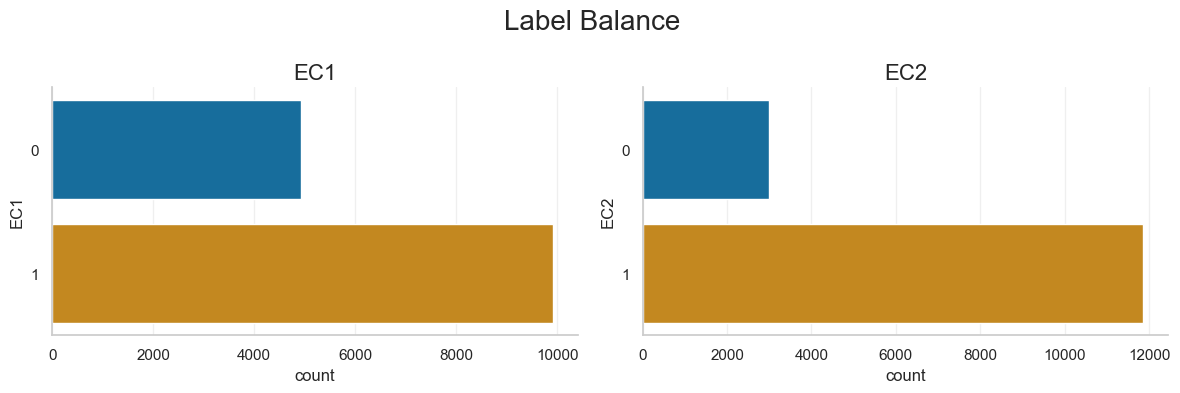

In [13]:
figure, ax = plt.subplots(1, 2, figsize=(12, 4))
ax = ax.flatten()

sns.countplot(data=train_data, 
              y='EC1',
              ax=ax[0])

sns.countplot(data=train_data, 
              y='EC2',
              ax=ax[1])

ax[0].set_title('EC1')
ax[1].set_title('EC2')

plt.suptitle('Label Balance', fontsize=20) 

plt.tight_layout()
plt.show()

## Pairplots

In [14]:
train_data.columns

Index(['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
       'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'],
      dtype='object')

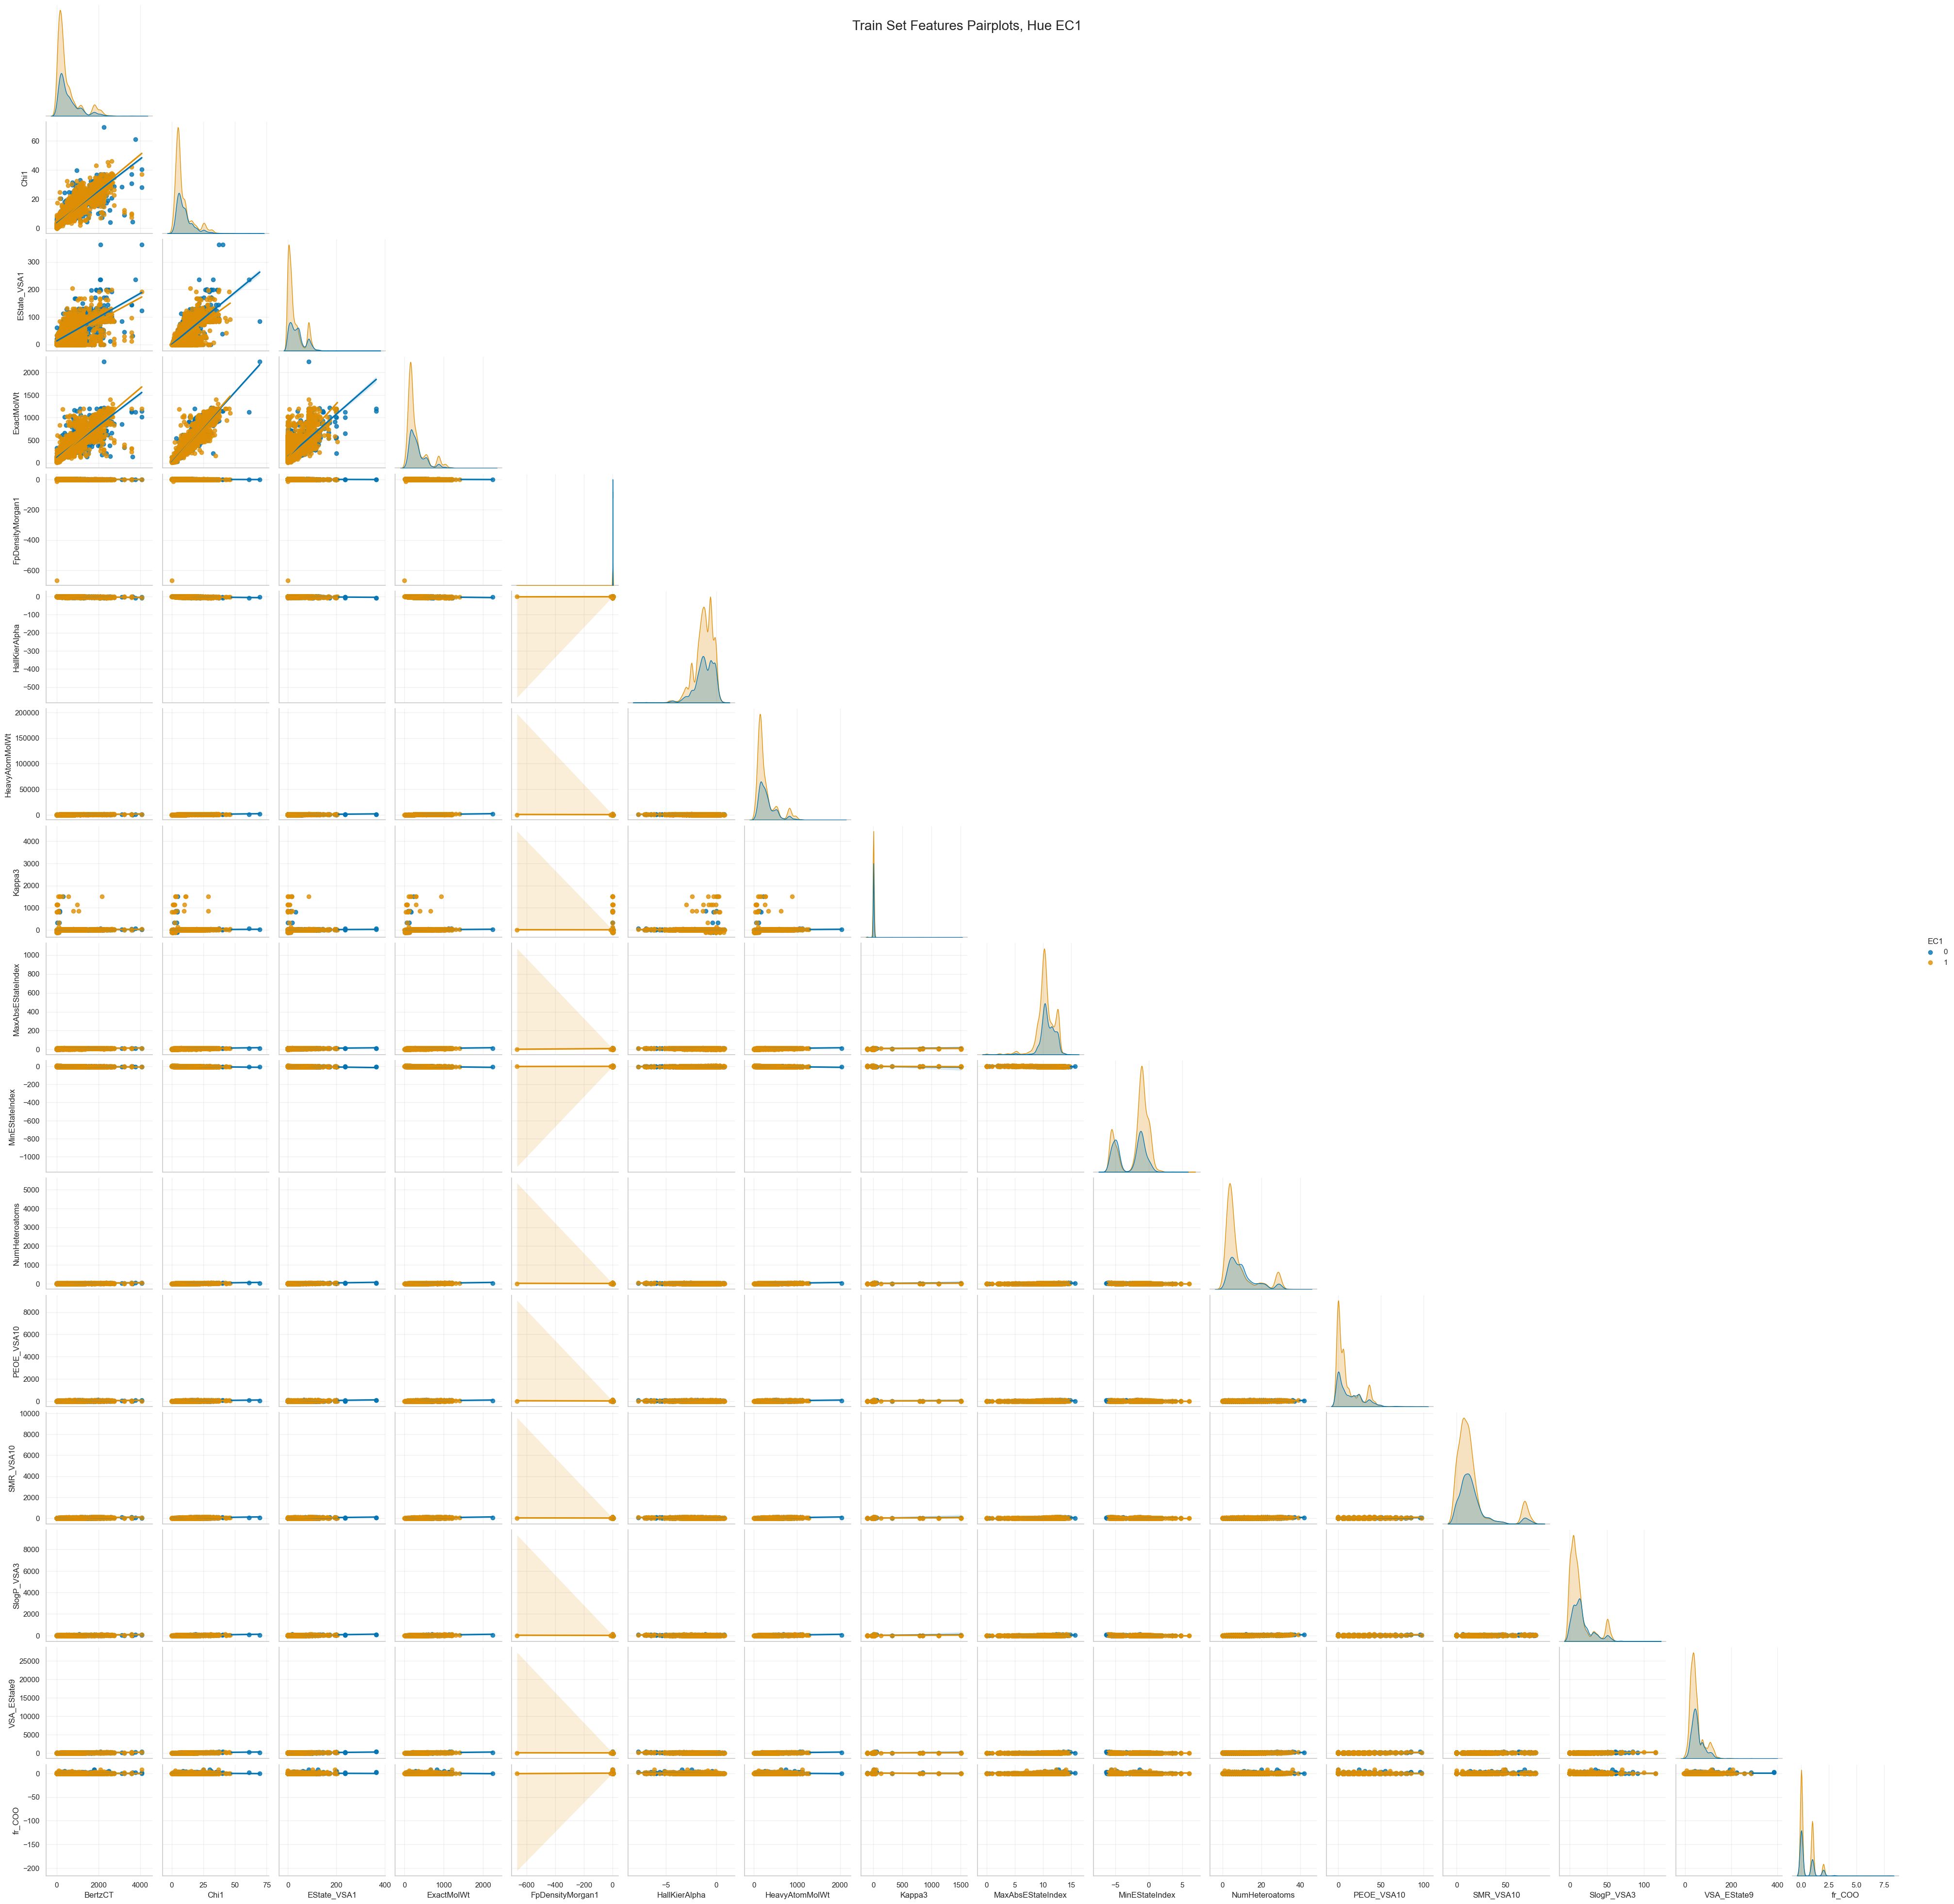

In [21]:
sns.pairplot(train_data[['BertzCT', 'Chi1', 
       'EState_VSA1', 'ExactMolWt', 'FpDensityMorgan1', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 
     'SMR_VSA10', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'EC1']],
             hue='EC1',
             kind="reg",
             diag_kind='kde',
             corner=True)

plt.suptitle('Train Set Features Pairplots, Hue EC1', 
             fontsize=20)

plt.show()

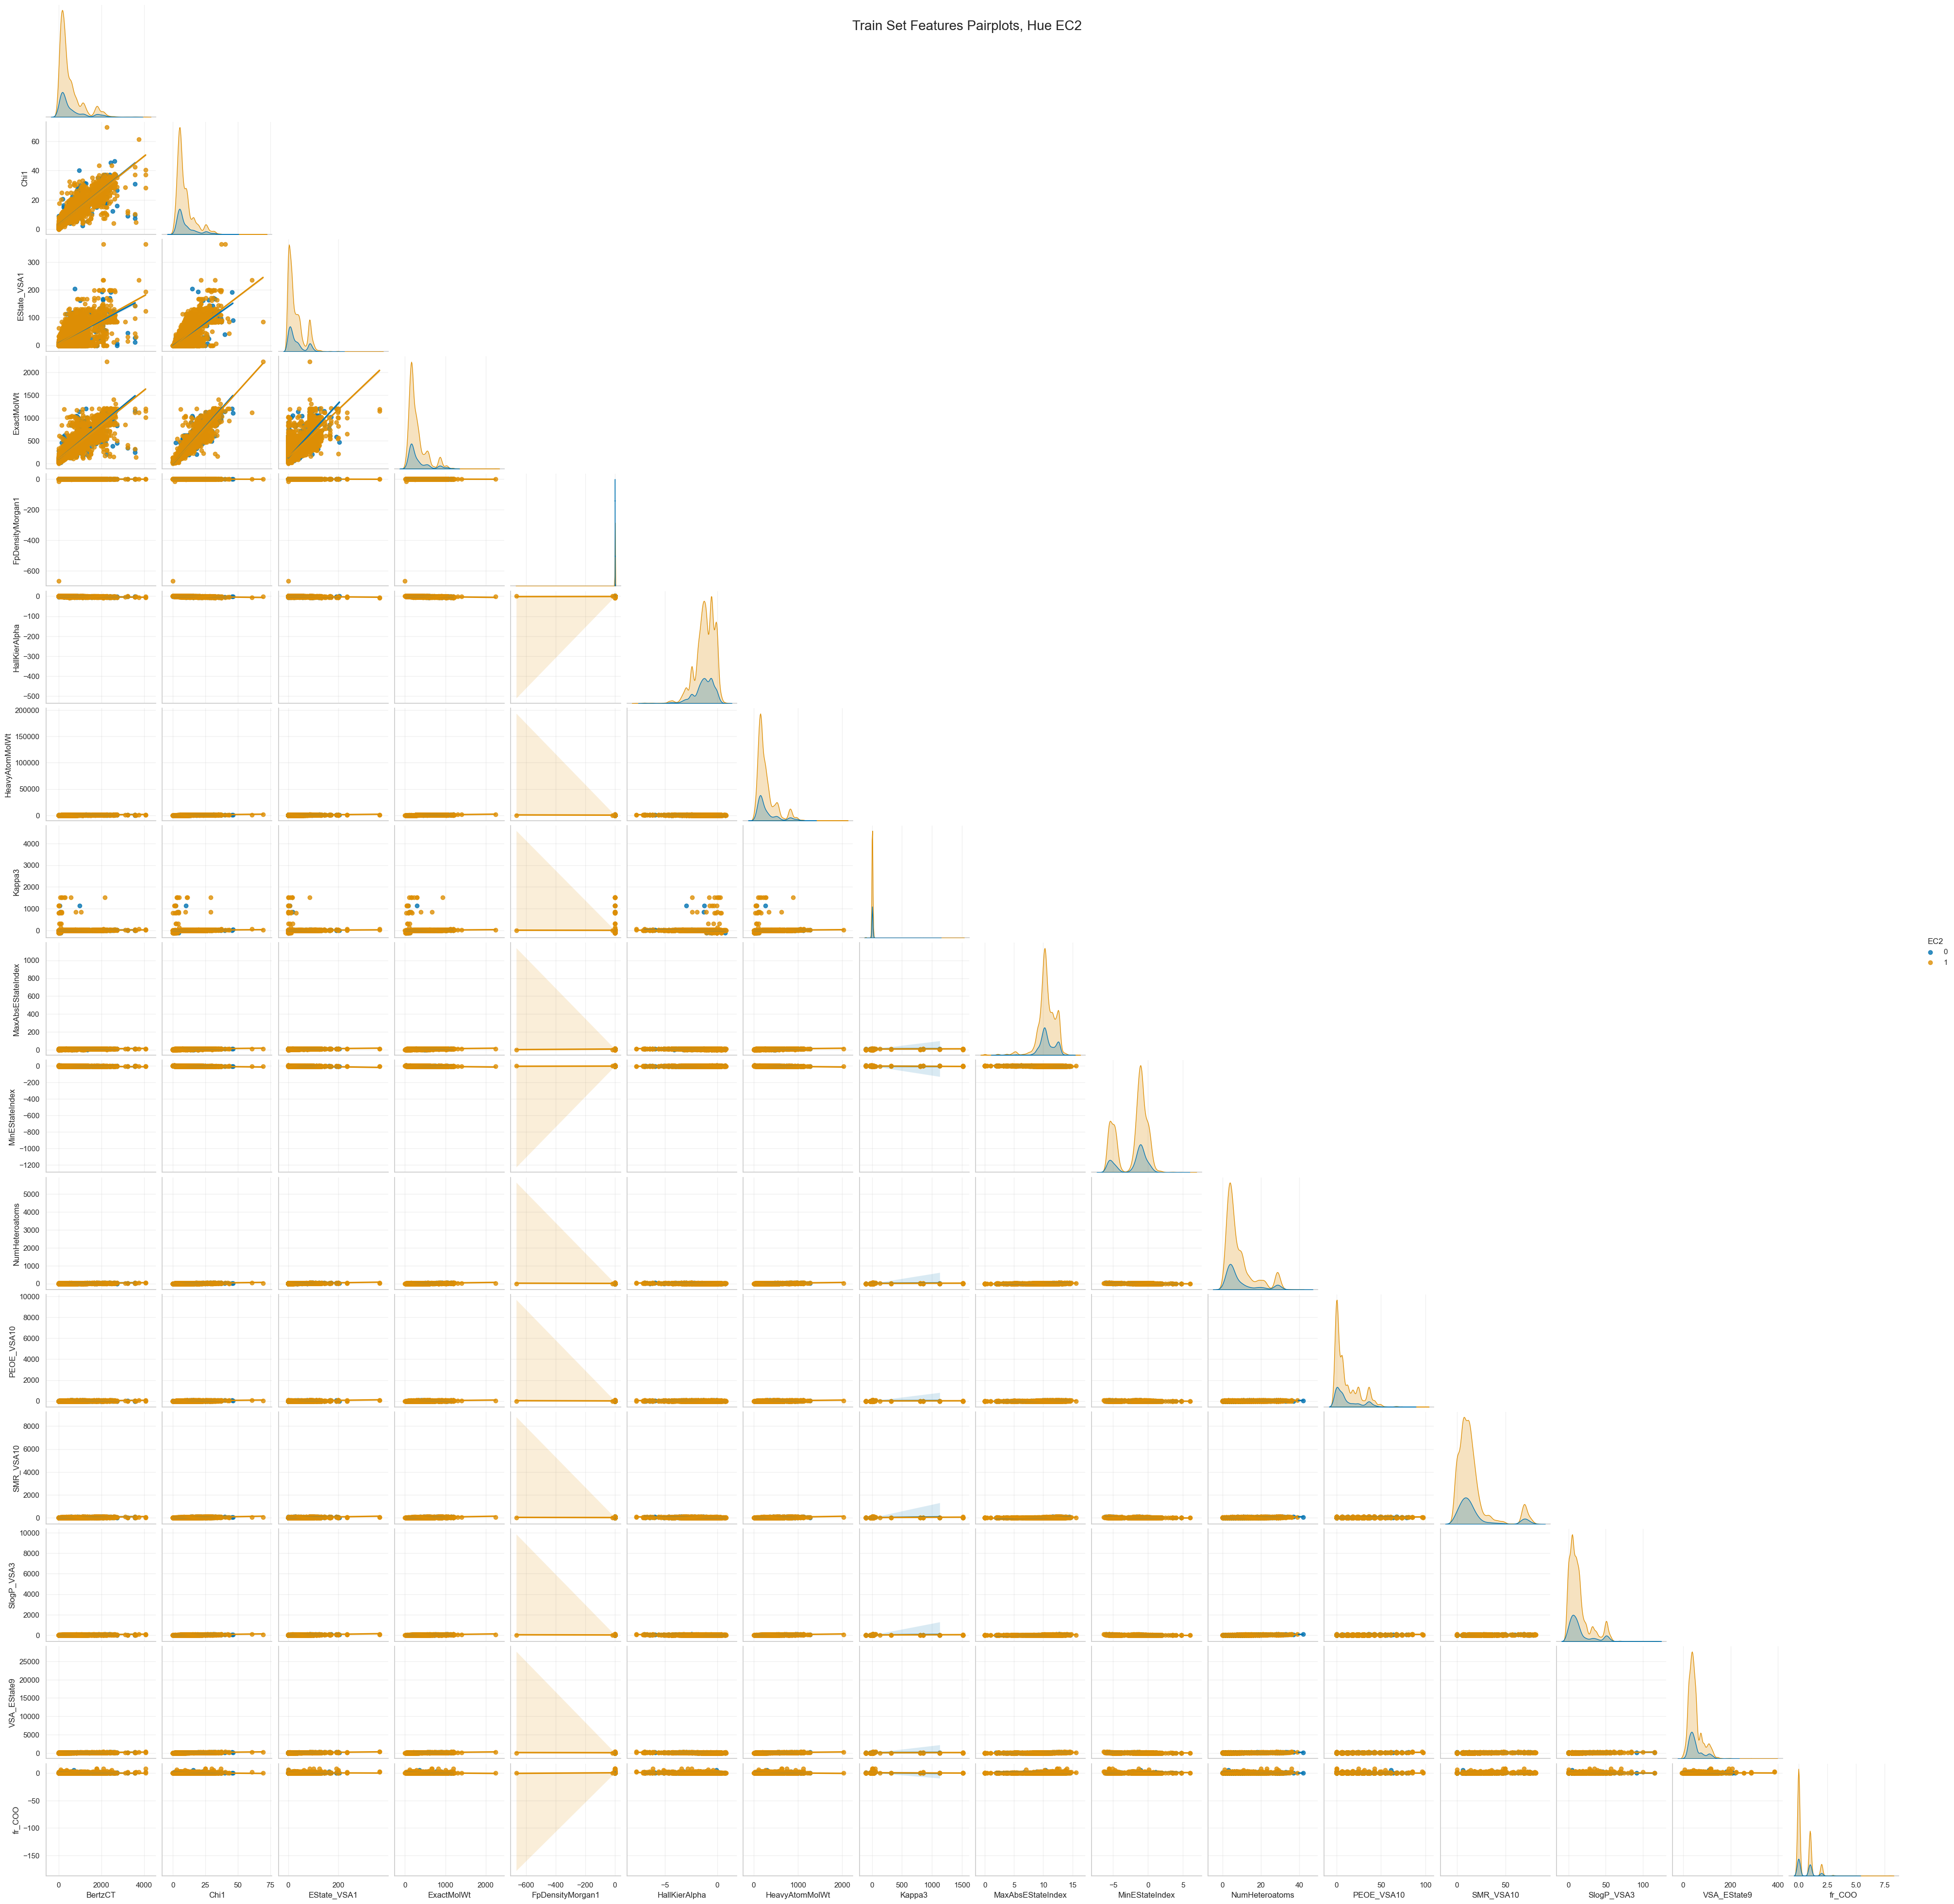

In [22]:
sns.pairplot(train_data[['BertzCT', 'Chi1', 
       'EState_VSA1', 'ExactMolWt', 'FpDensityMorgan1', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 
     'SMR_VSA10', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'EC2']],
             hue='EC2',
             kind="reg",
             diag_kind='kde',
             corner=True)

plt.suptitle('Train Set Features Pairplots, Hue EC2', 
             fontsize=20)

plt.show()